In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

## Load Dataset

In [2]:
df = pd.read_excel('main_data.xlsx')

In [3]:
print(df.head())

                                            Comments Sentiment
0                                    খেতে জঘন্য লাগে  Positive
1           টাইটেলে সাইন্স বানান টাই ভুল Science হবে  Negative
2                             ভাইয়া ভাবিটা অনেক কিউট  Positive
3  ভারতের ত্রকটা প্রদেশের সমান পাকিশ্তান ভাই কে ক...  Negative
4                       খুব সুন্দর ভিডিও করেছেন আপনি  Positive


## Remove null values

In [4]:
df.dropna(inplace=True)

**Text Cleaning**

In [5]:
stopwords = set(["এবং", "কিন্তু", "তবে", "তাই", "কিভাবে", "কোথায়", "কি", "কখন", "কেন", "যখন", "তখন", "যদি", "তাহলে", "একজন", "কিছু"])

def clean_text(text):
    # Remove punctuation and numbers
    text = re.sub(f"[{string.punctuation}]", " ", text)
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    text = " ".join([word for word in text.split() if word not in stopwords])
    return text

df['cleaned_comments'] = df['Comments'].apply(clean_text)

## Level Encoding

In [6]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Sentiment'])

## Train Test Split

In [7]:
X = df['cleaned_comments']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Confusion Matrix Function

In [8]:
def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{title} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

## Plot ROC curve function

In [9]:
def plot_roc_curve(y_test, y_prob, model_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')

# Binarize y_test for binary classification ROC curves
y_test_bin = label_binarize(y_test, classes=[0, 1]).ravel()

# Create a plot for ROC curves
plt.figure(figsize=(10, 7))

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

**Dataset Roc Curve**

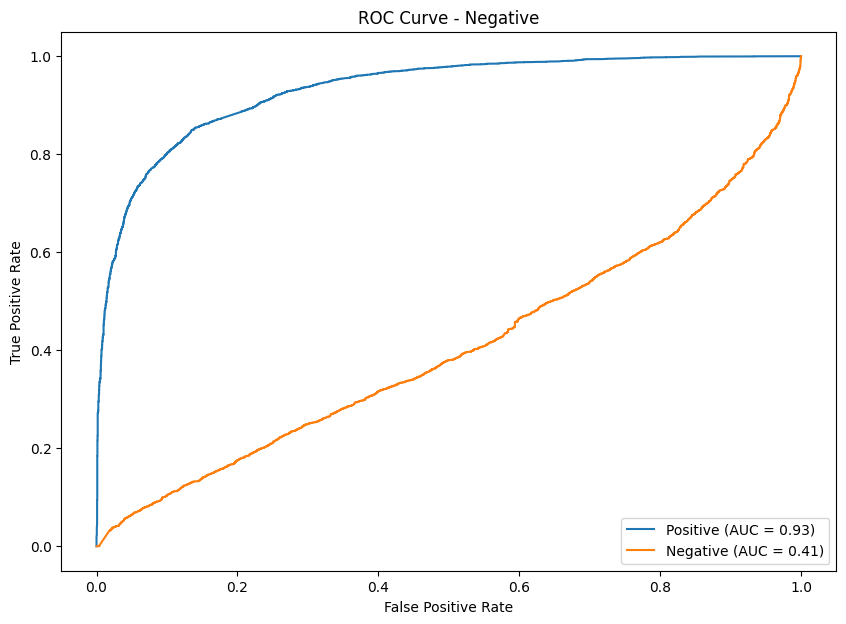

In [10]:
# Create a text preprocessing and classification pipeline
model = Pipeline([
    ('vect', CountVectorizer()),   # Convert text to token counts
    ('tfidf', TfidfTransformer()), # Convert counts to TF-IDF
    ('clf', OneVsRestClassifier(LogisticRegression()))  # Multiclass classifier using Logistic Regression
])

# Train the model
model.fit(X_train, y_train)

# Get probability estimates for the test data
y_prob = model.predict_proba(X_test)

# Plot ROC curve for each class (positive and negative)
plt.figure(figsize=(10, 7))

# Binarize y_test for ROC AUC calculation
y_test_bin = label_binarize(y_test, classes=[0, 1])

# Plot ROC curve for the positive class (class 1)
plot_roc_curve(y_test_bin.ravel(), y_prob[:, 1], 'Positive')

# Plot ROC curve for the negative class (class 0)
plot_roc_curve(1 - y_test_bin.ravel(), y_prob[:, 0], 'Negative')

# Show the plot
plt.show()

## Multinomial Naive Bayes

In [11]:
pipeline_mnb = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
])
pipeline_mnb.fit(X_train, y_train)
y_pred_mnb = pipeline_mnb.predict(X_test)
accuracy_mnb = accuracy_score(y_test, y_pred_mnb)
print(f"Multinomial Naive Bayes (MNB) - Model Accuracy: {accuracy_mnb * 100:.2f}%")

Multinomial Naive Bayes (MNB) - Model Accuracy: 84.90%


**Classification Report**

In [12]:
print("Multinomial Naive Bayes (MNB):")
print(classification_report(y_test, y_pred_mnb))

Multinomial Naive Bayes (MNB):
              precision    recall  f1-score   support

           1       0.84      0.86      0.85      4639
           2       0.86      0.84      0.85      4683

    accuracy                           0.85      9322
   macro avg       0.85      0.85      0.85      9322
weighted avg       0.85      0.85      0.85      9322



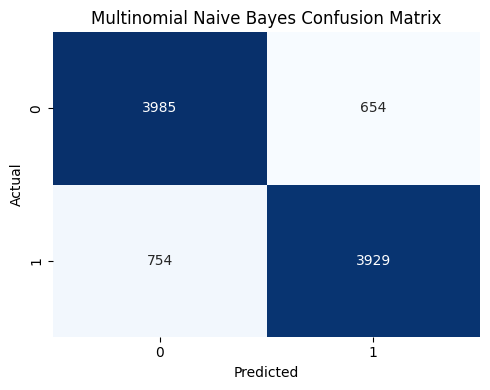

In [13]:
plot_confusion_matrix(y_test, y_pred_mnb, 'Multinomial Naive Bayes')

**Roc Curve**

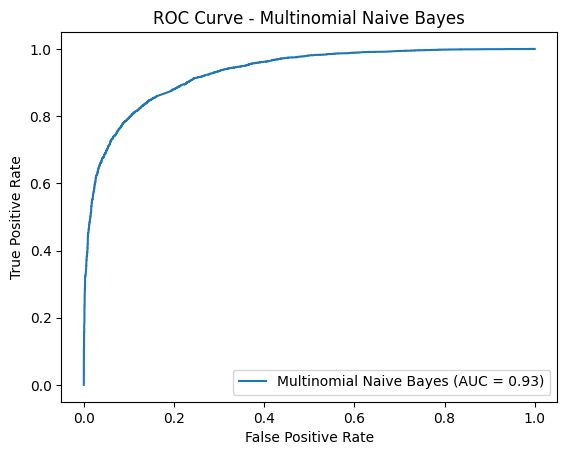

In [14]:
y_prob_mnb = pipeline_mnb.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test_bin, y_prob_mnb, 'Multinomial Naive Bayes')

## Bernoulli Naive Bayes

In [15]:
pipeline_bnb = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', BernoulliNB()),
])
pipeline_bnb.fit(X_train, y_train)
y_pred_bnb = pipeline_bnb.predict(X_test)
accuracy_bnb = accuracy_score(y_test, y_pred_bnb)
print(f"Bernoulli Naive Bayes (BNB) - Model Accuracy: {accuracy_bnb * 100:.2f}%")

Bernoulli Naive Bayes (BNB) - Model Accuracy: 82.78%


**Classification Report**

In [16]:
print("Bernoulli Naive Bayes (BNB):")
print(classification_report(y_test, y_pred_bnb))

Bernoulli Naive Bayes (BNB):
              precision    recall  f1-score   support

           1       0.89      0.74      0.81      4639
           2       0.78      0.91      0.84      4683

    accuracy                           0.83      9322
   macro avg       0.84      0.83      0.83      9322
weighted avg       0.84      0.83      0.83      9322



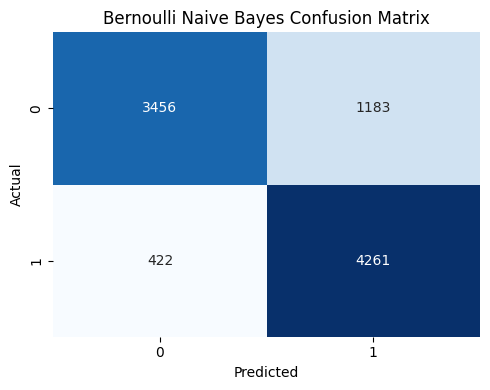

In [17]:
plot_confusion_matrix(y_test, y_pred_bnb, 'Bernoulli Naive Bayes')

**Roc Curve**

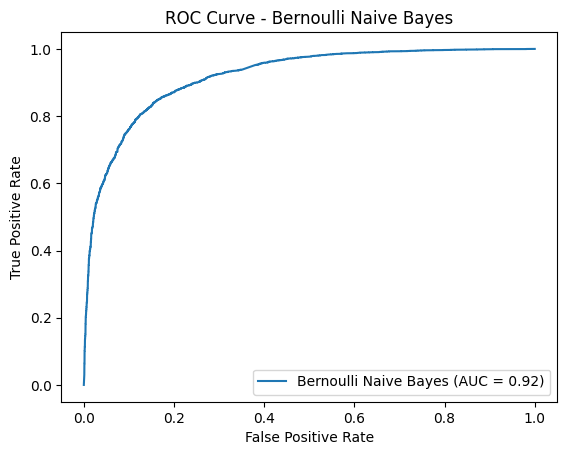

In [18]:
y_prob_bnb = pipeline_bnb.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test_bin, y_prob_bnb, 'Bernoulli Naive Bayes')

## Gaussian Naive Bayes

In [19]:
vectorizer = CountVectorizer()
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(vectorizer.fit_transform(X_train)).toarray()  # Dense array
X_test_tfidf = tfidf_transformer.transform(vectorizer.transform(X_test)).toarray()  # Dense array

gnb = GaussianNB()
gnb.fit(X_train_tfidf, y_train)
y_pred_gnb = gnb.predict(X_test_tfidf)
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print(f"Gaussian Naive Bayes (GNB) - Model Accuracy: {accuracy_gnb * 100:.2f}%")

Gaussian Naive Bayes (GNB) - Model Accuracy: 64.51%


**Classification Report**

In [20]:
print("Gaussian Naive Bayes (GNB):")
print(classification_report(y_test, y_pred_gnb))

Gaussian Naive Bayes (GNB):
              precision    recall  f1-score   support

           1       0.95      0.30      0.46      4639
           2       0.59      0.98      0.74      4683

    accuracy                           0.65      9322
   macro avg       0.77      0.64      0.60      9322
weighted avg       0.77      0.65      0.60      9322



**Confusion Matrix**

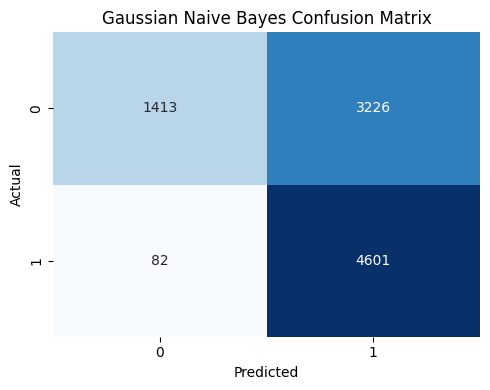

In [21]:
plot_confusion_matrix(y_test, y_pred_gnb, 'Gaussian Naive Bayes')

**Roc Curve**

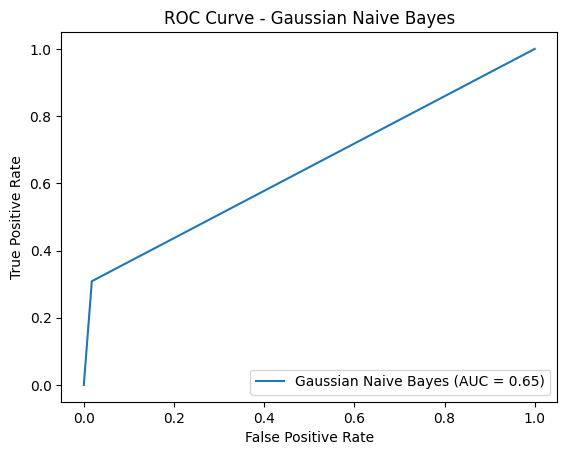

In [22]:
y_prob_gnb = gnb.predict_proba(X_test_tfidf)[:, 1]
plot_roc_curve(y_test_bin, y_prob_gnb, 'Gaussian Naive Bayes')

## Logistic Regression

In [23]:
pipeline_lr = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression(max_iter=1000)),
])
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression - Model Accuracy: {accuracy_lr * 100:.2f}%")

Logistic Regression - Model Accuracy: 85.73%


**Classification Report**

In [24]:
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression:
              precision    recall  f1-score   support

           1       0.86      0.85      0.86      4639
           2       0.85      0.87      0.86      4683

    accuracy                           0.86      9322
   macro avg       0.86      0.86      0.86      9322
weighted avg       0.86      0.86      0.86      9322



**Confusion Matrix**

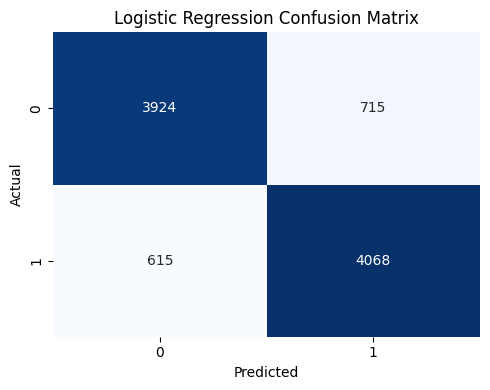

In [25]:
plot_confusion_matrix(y_test, y_pred_lr, 'Logistic Regression')

**Roc Curve**

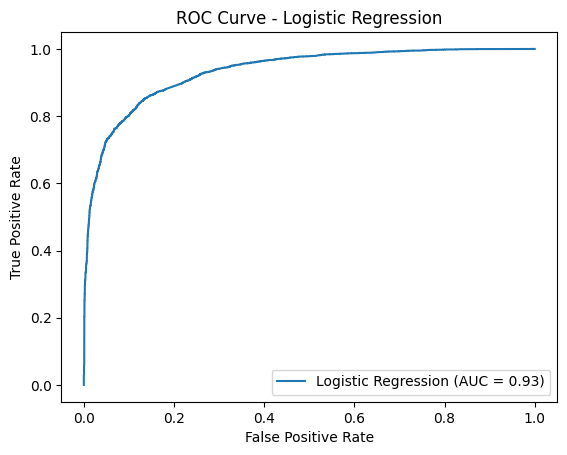

In [26]:
y_prob_lr = pipeline_lr.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test_bin, y_prob_lr, 'Logistic Regression')

## Decision Tree (CART)

In [27]:
pipeline_cart = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', DecisionTreeClassifier(criterion='gini', splitter='best')),
])
pipeline_cart.fit(X_train, y_train)
y_pred_cart = pipeline_cart.predict(X_test)
accuracy_cart = accuracy_score(y_test, y_pred_cart)
print(f"Decision Tree (CART) - Model Accuracy: {accuracy_cart * 100:.2f}%")

Decision Tree (CART) - Model Accuracy: 85.35%


**Classification Report**

In [28]:
print("Decision Tree (CART):")
print(classification_report(y_test, y_pred_cart))

Decision Tree (CART):
              precision    recall  f1-score   support

           1       0.87      0.84      0.85      4639
           2       0.84      0.87      0.86      4683

    accuracy                           0.85      9322
   macro avg       0.85      0.85      0.85      9322
weighted avg       0.85      0.85      0.85      9322



**Confusion Matrix**

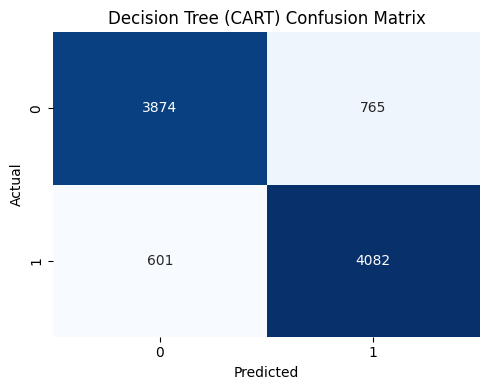

In [29]:
plot_confusion_matrix(y_test, y_pred_cart, 'Decision Tree (CART)')

**Roc Curve**

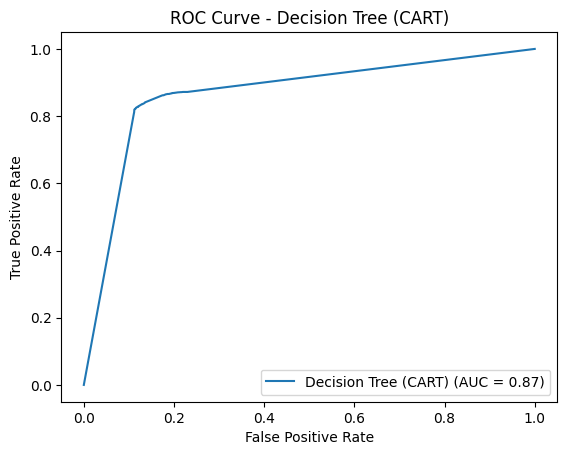

In [30]:
y_prob_cart = pipeline_cart.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test_bin, y_prob_cart, 'Decision Tree (CART)')

## Decision Tree (ID3)

In [31]:
pipeline_id3 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', DecisionTreeClassifier(criterion='entropy')),
])
pipeline_id3.fit(X_train, y_train)
y_pred_id3 = pipeline_id3.predict(X_test)
accuracy_id3 = accuracy_score(y_test, y_pred_id3)
print(f"Decision Tree (ID3) - Model Accuracy: {accuracy_id3 * 100:.2f}%")

Decision Tree (ID3) - Model Accuracy: 85.72%


**Classification Report**

In [32]:
print("Decision Tree (ID3):")
print(classification_report(y_test, y_pred_id3))

Decision Tree (ID3):
              precision    recall  f1-score   support

           1       0.87      0.84      0.85      4639
           2       0.84      0.88      0.86      4683

    accuracy                           0.86      9322
   macro avg       0.86      0.86      0.86      9322
weighted avg       0.86      0.86      0.86      9322



**Confusion Matrix**

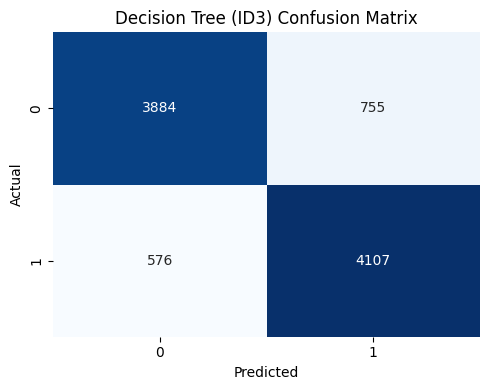

In [33]:
plot_confusion_matrix(y_test, y_pred_id3, 'Decision Tree (ID3)')

**Roc Curve**

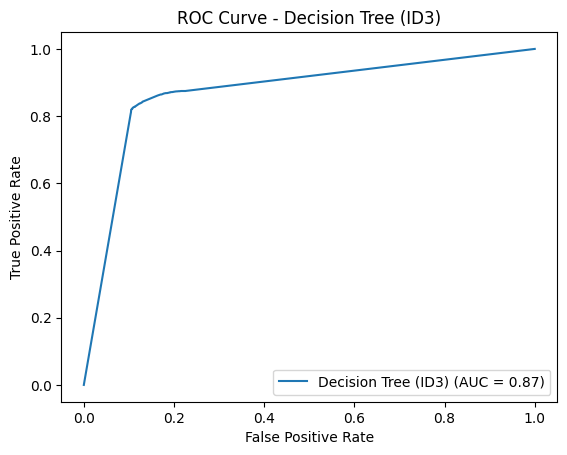

In [34]:
y_prob_id3 = pipeline_id3.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test_bin, y_prob_id3, 'Decision Tree (ID3)')

## K-Nearest Neighbors (KNN)

In [35]:
pipeline_knn = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', KNeighborsClassifier(n_neighbors=5)),
])
pipeline_knn.fit(X_train, y_train)
y_pred_knn = pipeline_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"K-Nearest Neighbors (KNN) - Model Accuracy: {accuracy_knn * 100:.2f}%")

K-Nearest Neighbors (KNN) - Model Accuracy: 73.96%


**Classification Report**

In [36]:
print("K-Nearest Neighbors (KNN):")
print(classification_report(y_test, y_pred_knn))

K-Nearest Neighbors (KNN):
              precision    recall  f1-score   support

           1       0.83      0.60      0.70      4639
           2       0.69      0.88      0.77      4683

    accuracy                           0.74      9322
   macro avg       0.76      0.74      0.73      9322
weighted avg       0.76      0.74      0.73      9322



**Confusion Matrix**

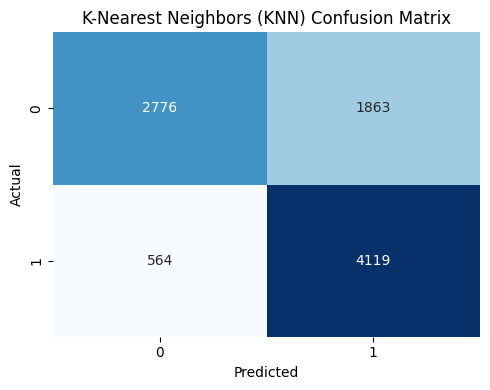

In [37]:
plot_confusion_matrix(y_test, y_pred_knn, 'K-Nearest Neighbors (KNN)')

**Roc Curve**

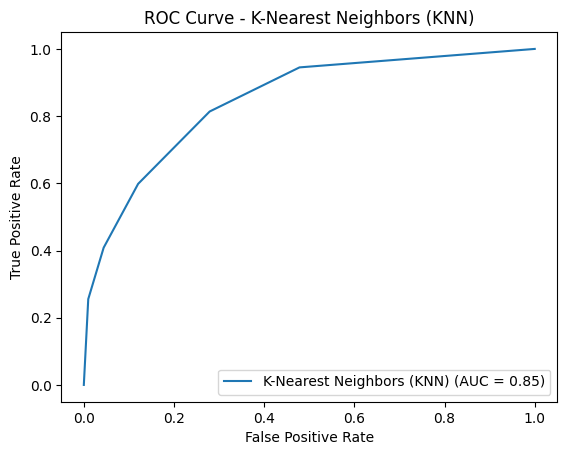

In [38]:
y_prob_knn = pipeline_knn.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test_bin, y_prob_knn, 'K-Nearest Neighbors (KNN)')

## Support Vector Machine (SVM)

In [39]:
pipeline_svm = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC(kernel='linear')),
])
pipeline_svm.fit(X_train, y_train)
y_pred_svm = pipeline_svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Support Vector Machine (SVM) - Model Accuracy: {accuracy_svm * 100:.2f}%")

Support Vector Machine (SVM) - Model Accuracy: 85.59%


**Classification Report**

In [40]:
print("Support Vector Machine (SVM):")
print(classification_report(y_test, y_pred_svm))

Support Vector Machine (SVM):
              precision    recall  f1-score   support

           1       0.87      0.84      0.85      4639
           2       0.84      0.88      0.86      4683

    accuracy                           0.86      9322
   macro avg       0.86      0.86      0.86      9322
weighted avg       0.86      0.86      0.86      9322



**Confusion Matrix**

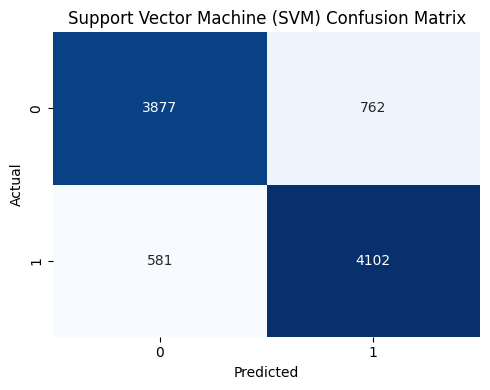

In [41]:
plot_confusion_matrix(y_test, y_pred_svm, 'Support Vector Machine (SVM)')

**Roc Curve**

In [52]:
#y_prob_svm = pipeline_svm.decision_function(X_test)
#plot_roc_curve(y_test_bin, y_prob_svm, 'Support Vector Machine (SVM)')

## C4.5 with DecisionTreeClassifier

In [53]:
pipeline_c45 = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', DecisionTreeClassifier(criterion='entropy', min_samples_split=2)),
])
pipeline_c45.fit(X_train, y_train)
y_pred_c45 = pipeline_c45.predict(X_test)
accuracy_c45 = accuracy_score(y_test, y_pred_c45)
print(f"C4.5 - Model Accuracy: {accuracy_c45 * 100:.2f}%")

C4.5 - Model Accuracy: 6.24%


**Classification Report**

In [54]:
print("C4.5:")
print(classification_report(y_test, y_pred_c45))

C4.5:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4639
           1       0.13      0.12      0.13      4683
           2       0.00      0.00      0.00         0

    accuracy                           0.06      9322
   macro avg       0.04      0.04      0.04      9322
weighted avg       0.07      0.06      0.06      9322



C:\Users\saifm\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\saifm\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\saifm\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(

**Confusion Matrix**

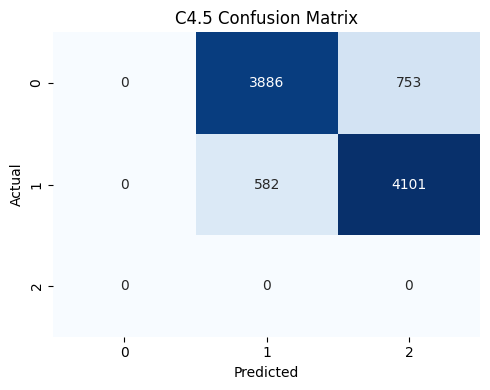

In [55]:
plot_confusion_matrix(y_test, y_pred_c45, 'C4.5')

**Roc Curve**

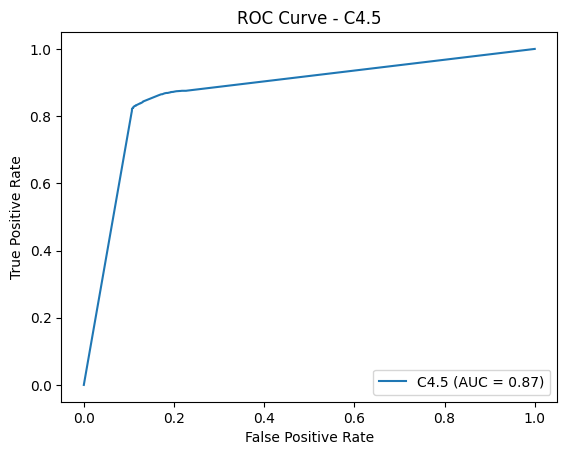

In [56]:
y_prob_c45 = pipeline_c45.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test_bin, y_prob_c45, 'C4.5')

## Accuracy Chart

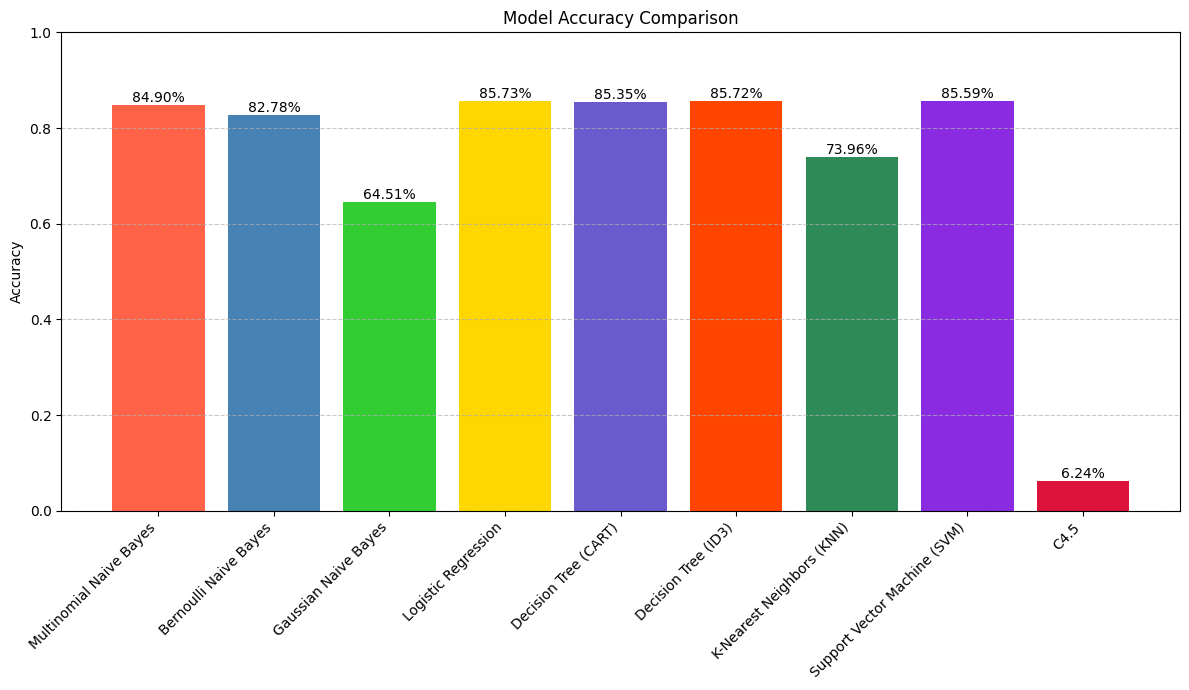

In [57]:
models = [
    'Multinomial Naive Bayes',
    'Bernoulli Naive Bayes',
    'Gaussian Naive Bayes',
    'Logistic Regression',
    'Decision Tree (CART)',
    'Decision Tree (ID3)',
    'K-Nearest Neighbors (KNN)',
    'Support Vector Machine (SVM)',
    'C4.5'
]
accuracies = [
    accuracy_mnb,
    accuracy_bnb,
    accuracy_gnb,
    accuracy_lr,
    accuracy_cart,
    accuracy_id3,
    accuracy_knn,
    accuracy_svm,
    accuracy_c45
]

# Create a vertical bar chart
plt.figure(figsize=(12, 7))
bars = plt.bar(models, accuracies, color=['#FF6347', '#4682B4', '#32CD32', '#FFD700', '#6A5ACD', '#FF4500', '#2E8B57', '#8A2BE2', '#DC143C'])

# Add accuracy values to bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             f'{bar.get_height() * 100:.2f}%', 
             va='bottom', ha='center', fontsize=10, color='black')

# Add labels and title
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 (since accuracy is between 0 and 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()

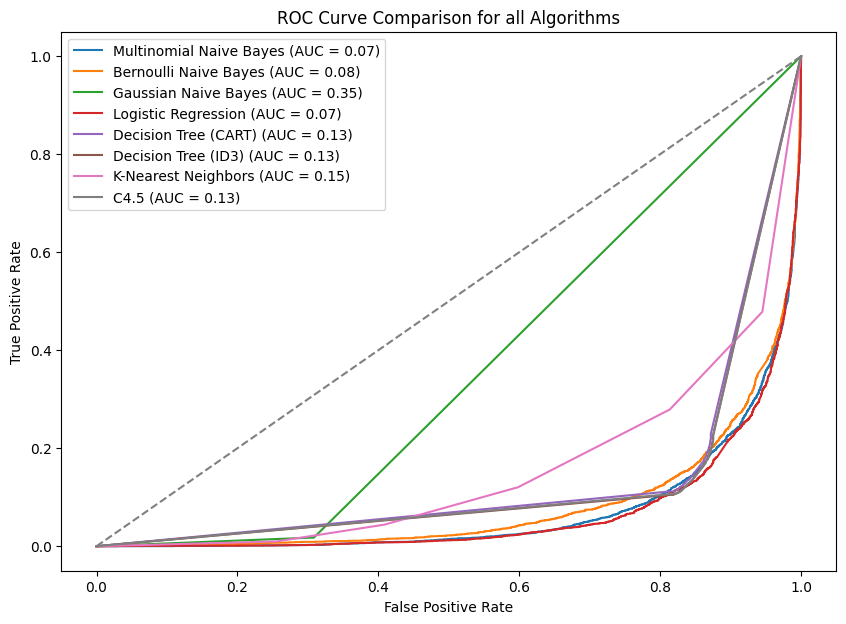

In [59]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize labels: Assume 0 = negative, 1 = positive
y_test_bin = label_binarize(y_test, classes=[0, 1]).ravel()

# Function to plot ROC curve
def plot_roc_curve(y_test_bin, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_test_bin, y_prob)
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='upper left')

# Create a plot for ROC curves
plt.figure(figsize=(10, 7))

# Multinomial Naive Bayes (MNB)
y_prob_mnb = pipeline_mnb.predict_proba(X_test)[:, 1]  # Probabilities for positive class
plot_roc_curve(y_test_bin, y_prob_mnb, 'Multinomial Naive Bayes')

# Bernoulli Naive Bayes (BNB)
y_prob_bnb = pipeline_bnb.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test_bin, y_prob_bnb, 'Bernoulli Naive Bayes')

# Gaussian Naive Bayes (GNB)
y_prob_gnb = gnb.predict_proba(X_test_tfidf)[:, 1]
plot_roc_curve(y_test_bin, y_prob_gnb, 'Gaussian Naive Bayes')

# Logistic Regression
y_prob_lr = pipeline_lr.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test_bin, y_prob_lr, 'Logistic Regression')

# Decision Tree (CART)
y_prob_cart = pipeline_cart.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test_bin, y_prob_cart, 'Decision Tree (CART)')

# Decision Tree (ID3)
y_prob_id3 = pipeline_id3.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test_bin, y_prob_id3, 'Decision Tree (ID3)')

# K-Nearest Neighbors (KNN)
y_prob_knn = pipeline_knn.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test_bin, y_prob_knn, 'K-Nearest Neighbors')

# Support Vector Machine (SVM) (For SVM, we need to use decision function instead of predict_proba)
#y_prob_svm = pipeline_svm.decision_function(X_test)
#plot_roc_curve(y_test_bin, y_prob_svm, 'Support Vector Machine')

# C4.5
y_prob_c45 = pipeline_c45.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test_bin, y_prob_c45, 'C4.5')

# Finalize ROC plot
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random classifier
plt.title('ROC Curve Comparison for all Algorithms')
plt.show()
